# Time Series Techniques 

Features Def:
1. Date: date in format yyyy-mm-dd
2. Time: time in format hh:mm:ss
3. Global_active_power: household global minute-averaged active power (in kilowatt).
4. Global_reactive_power: household global minute-averaged reactive power (in kilowatt).
5. Voltage: minute-averaged voltage (in volt).
6. Global_intensity: household global minute-averaged current intensity (in ampere).
7. Sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven, and a microwave.
8. Sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. Sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_squared_error
import pickle

Using TensorFlow backend.


## Helper Functions

In [2]:
def import_Data(path):
    df_list=[]
    for year in [2008,2009,2010]:
        for month in range(13):
            for date in range(32):
                filePath="%s/%d/%d/%d"%(path,year,month,date)
                if os.path.exists(filePath):
                    temp_df=pd.read_csv(filePath)
                    df_list.append(temp_df)
    df=pd.concat(df_list,axis=0)

    df["Date"]=pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df.drop(columns=["Time"],inplace=True)
    df["Global_active_power"] = pd.to_numeric(df["Global_active_power"],errors='coerce')
    df["Global_reactive_power"] = pd.to_numeric(df["Global_reactive_power"],errors='coerce')
    df["Voltage"] = pd.to_numeric(df["Voltage"],errors='coerce')
    df["Global_intensity"] = pd.to_numeric(df["Global_intensity"],errors='coerce')
    df["Sub_metering_1"] = pd.to_numeric(df["Sub_metering_1"],errors='coerce')
    df["Sub_metering_2"] = pd.to_numeric(df["Sub_metering_2"],errors='coerce')
    df["Sub_metering_3"] = pd.to_numeric(df["Sub_metering_3"],errors='coerce')    
    df.set_index(['Date'],inplace=True)
    return df

def univariate_analysis(dataset):

    values = dataset.values
    # specify columns to plot
    groups = range(dataset.shape[1])
    # plot each column
    pyplot.figure(figsize=(20,16))
    for group in groups:
        pyplot.subplot(len(groups),1,group+1)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
    pyplot.show()
    
    #Checking min, Max and outliers
    print(df.describe(percentiles=[.98,.95,.9,.75,.5,.25,.1,.05,.02]))

    #Univariate, Histogram and boxplot  - YOY
    data=df.copy()
    data['y']=data.index.year
    #data=data.loc[data.index.year==year_no,:]
    for col in df.columns:
        #for year_no in [2008,2009,2010]: 
        plt.figure(figsize=(16,4))

        pyplot.subplot(121)
        sns.distplot(df.loc[data.index.year==2008,col].dropna(), color='g',label="2008");
        sns.distplot(df.loc[data.index.year==2009,col].dropna(), color='r',label="2009");
        sns.distplot(df.loc[data.index.year==2010,col].dropna(), color='b',label="2010");

        pyplot.subplot(122)
        sns.boxplot(x='y', y=col, data=data)

        plt.show()


def lstm_Data_prep(df_treated, n_in=14, n_out=7, dropnan=True):
    """
    LSTM Data Preparation
    1. Setting up as supervised learning prob: I will frame the supervised learning problem as predicting the consumption at the current minute
    (t) given the consumption measurement and other features at the prior time step.
    
    2.Normalizing the input variables.
    
    ==========Variables=========
    Dataset = Data to be transformed
    n_in=number of lags required
    n_out=
    
    
    """
    

    
    agg_logic={'Global_active_power':'mean',
       'Global_reactive_power':'mean', 'Voltage':'mean', 'Global_intensity':'mean',
       'Sub_metering_1':'sum', 'Sub_metering_2':'sum', 'Sub_metering_3':'sum'}

    df_treated_day=df_treated.groupby(["date","week","month","year","dayofmonth","dayofweek"]).agg(agg_logic).reset_index().set_index("date")
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = pd.DataFrame(scaler.fit_transform(df_treated_day))
    n_vars=data.shape[1]

    
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def set_params(reframed):
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = 10000 
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y


## Missing Values

In [3]:
df=import_Data('/mnt/flipkart/cremo/users/jatin.dixit/temp/DSC_Worldquant/data')    
null_data = df[df.isnull().any(axis=1)]
#Good thing is entire row is missing or present.
print(null_data.shape[0], " Null rows out of total rows = ", df.shape[0])

#Forward filling the time series data
df_treated=df.fillna(method='ffill')

#Checking again for nulls 
null_data = df[df.isnull().any(axis=1)]

#No null found.
print(df.sum())
print(df_treated.sum())
#No major change in data

22044  Null rows out of total rows =  1527663
Global_active_power      1.612503e+06
Global_reactive_power    1.894104e+05
Voltage                  3.633594e+08
Global_intensity         6.821488e+06
Sub_metering_1           1.629127e+06
Sub_metering_2           1.757959e+06
Sub_metering_3           1.004938e+07
dtype: float64
Global_active_power      1.627522e+06
Global_reactive_power    1.909753e+05
Voltage                  3.686894e+08
Global_intensity         6.883720e+06
Sub_metering_1           1.635515e+06
Sub_metering_2           1.769728e+06
Sub_metering_3           1.013004e+07
dtype: float64


## Visualisation and Univariates and outliers checks

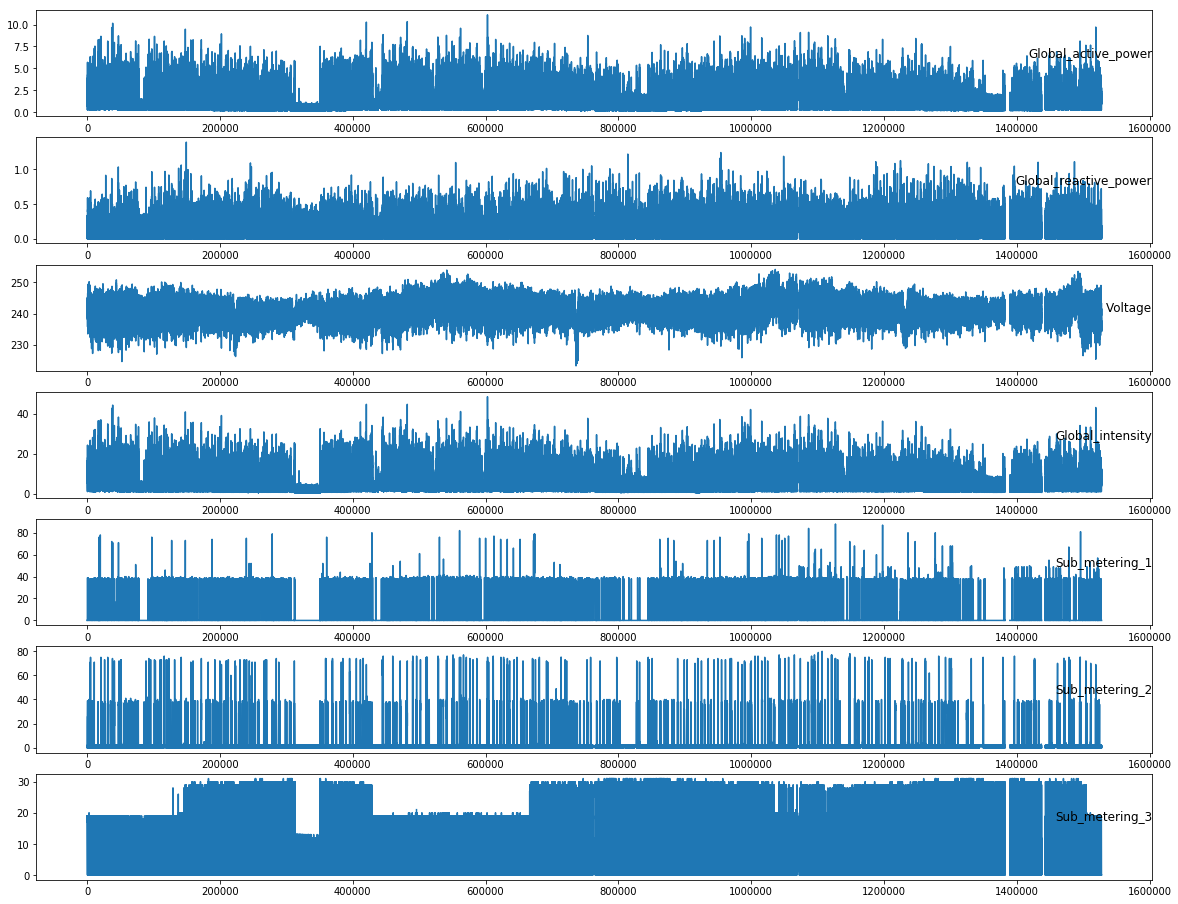

       Global_active_power  Global_reactive_power       Voltage  \
count         1.505619e+06           1.505619e+06  1.505619e+06   
mean          1.070990e+00           1.258024e-01  2.413355e+02   
std           1.007012e+00           1.140247e-01  2.948056e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
2%            1.500000e-01           0.000000e+00  2.349000e+02   
5%            1.940000e-01           0.000000e+00  2.365200e+02   
10%           2.340000e-01           0.000000e+00  2.377700e+02   
25%           3.200000e-01           5.000000e-02  2.395600e+02   
50%           6.200000e-01           1.000000e-01  2.413500e+02   
75%           1.514000e+00           1.960000e-01  2.431500e+02   
90%           2.354000e+00           2.720000e-01  2.449500e+02   
95%           3.062000e+00           3.420000e-01  2.461800e+02   
98%           3.978000e+00           4.160000e-01  2.476100e+02   
max           1.112200e+01           1.390000e+00  2.541500e+0

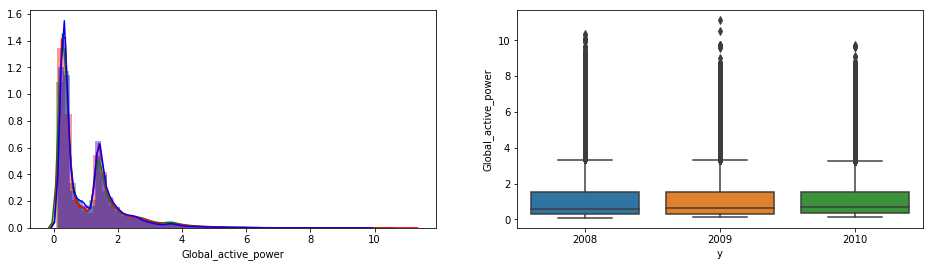

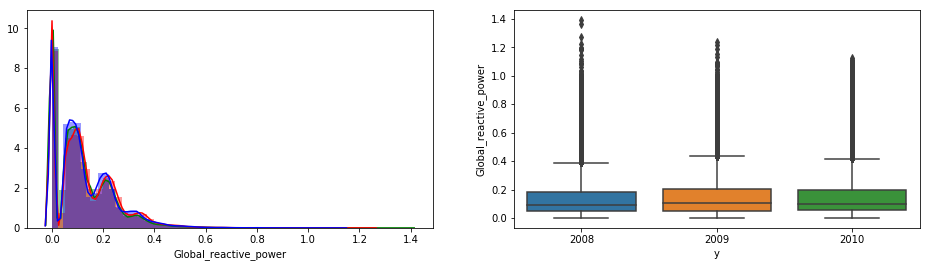

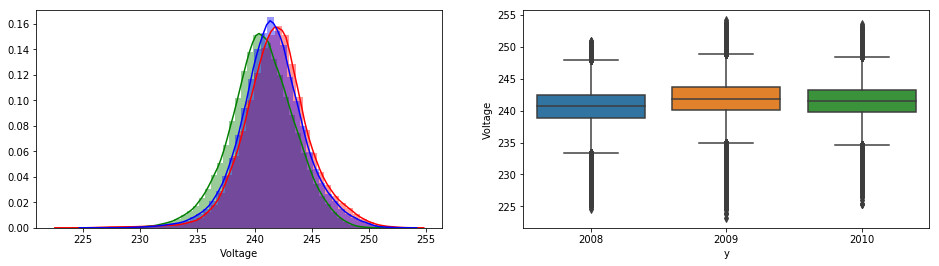

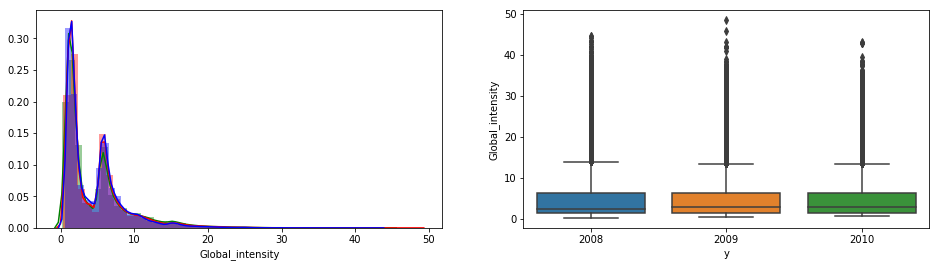

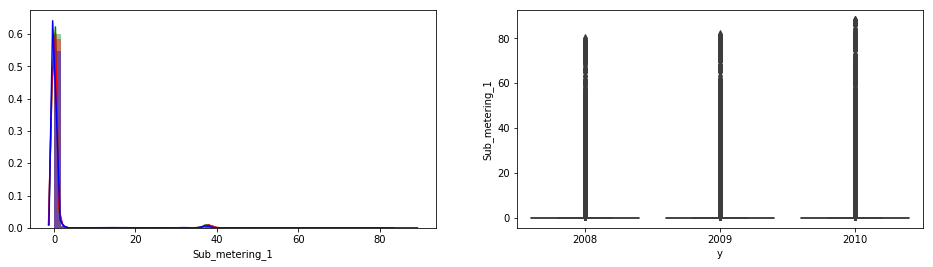

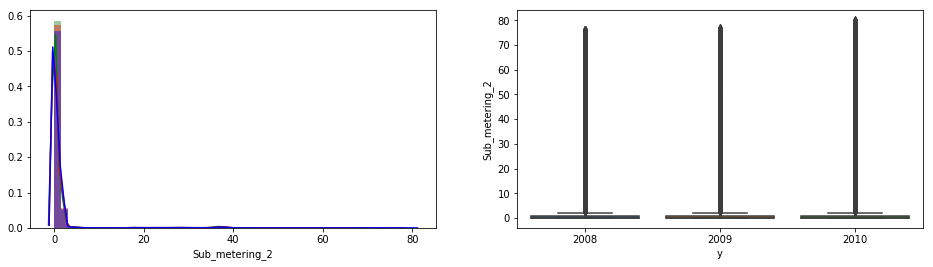

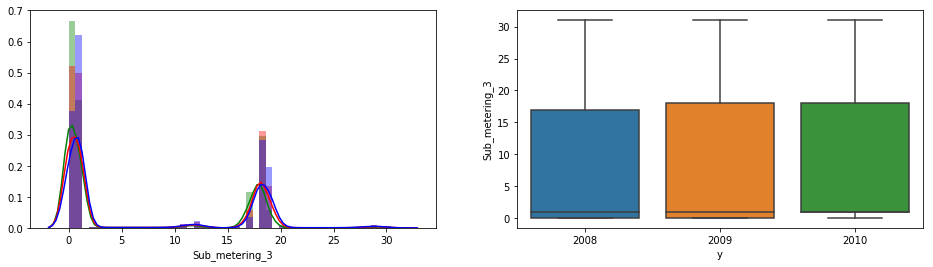

'\nThough max values are upto mean + (5-10)*stdev, they are still close to 98%iles, looks genuine tail values. Not treating any outliers. \n'

In [4]:
#Importing data and visualising features
univariate_analysis(df)

"""
Comment: The distributions (Histogram and Box Plots) looks very similar YOY
"""
"""
Though max values are upto mean + (5-10)*stdev, they are still close to 98%iles, looks genuine tail values. Not treating any outliers. 
"""

## Feature Eng

In [5]:
df_treated["total_power"]=df_treated["Global_active_power"]+df_treated["Global_reactive_power"]
df_treated["total_metering"]=df_treated["Sub_metering_1"]+df_treated["Sub_metering_2"]+df_treated["Sub_metering_3"]

## Bivariate analysis


In [6]:
df_treated.corr()
#There are huge correlations between active_power, global_intensity, total_power. As Power is prepotional to current at constant voltages and power factors.
# There is <10% correlation b/w metering1,2,3 which means these 3 demans are quite orthogonal to each other


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,total_power,total_metering
Global_active_power,1.000000,0.242571,-0.432786,0.998818,0.493764,0.413233,0.655391,0.994315,0.859461
Global_reactive_power,0.242571,1.000000,-0.129459,0.263626,0.117093,0.136177,0.097088,0.344491,0.180636
Voltage,-0.432786,-0.129459,1.000000,-0.444164,-0.202532,-0.160979,-0.295285,-0.433012,-0.366830
Global_intensity,0.998818,0.263626,-0.444164,1.000000,0.498929,0.418773,0.643207,0.995482,0.856048
Sub_metering_1,0.493764,0.117093,-0.202532,0.498929,1.000000,0.051602,0.097969,0.490663,0.568205
Sub_metering_2,0.413233,0.136177,-0.160979,0.418773,0.051602,1.000000,0.066888,0.414829,0.500301
Sub_metering_3,0.655391,0.097088,-0.295285,0.643207,0.097969,0.066888,1.000000,0.644872,0.754657
total_power,0.994315,0.344491,-0.433012,0.995482,0.490663,0.414829,0.644872,1.000000,0.851518
total_metering,0.859461,0.180636,-0.366830,0.856048,0.568205,0.500301,0.754657,0.851518,1.000000


## Seasonality checks

In [7]:
#Seasonality checks on [hour,day,week,month]
dim=["hour","day","week","month"]
dim="month"

df_treated["date"]=df_treated.index.date
df_treated["month"]=df_treated.index.month
df_treated["year"]=df_treated.index.year
df_treated["week"]=df_treated.index.week
df_treated["dayofmonth"]=df_treated.index.day
df_treated["dayofweek"]=df_treated.index.dayofweek
df_treated["hourofday"]=df_treated.index.hour
df_treated["yearmo"]=df_treated.index.year*100+df_treated.index.month
df_treated["yearwk"]=df_treated.index.year*100+df_treated.index.week
df_treated["yearday"]=df_treated.index.year*1000+df_treated.index.dayofyear


In [8]:
cols=[ 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

agg_logic={'Global_active_power':'mean',
       'Global_reactive_power':'mean', 'Voltage':'mean', 'Global_intensity':'mean',
       'Sub_metering_1':'sum', 'Sub_metering_2':'sum', 'Sub_metering_3':'sum'}

def check_seasonality1(df,x,hue):
    df_grouped = df.groupby([x,hue]).agg(agg_logic).reset_index()
    for col in cols:
        plt.figure(figsize=(16,4))
        ax1=sns.boxplot(x=x, y=col, data=df_grouped)
        plt.show()
    print("--------------------------------------------------------")

def check_seasonality2(df,x,hue):
    df_grouped = df.groupby([x,hue]).agg(agg_logic).reset_index()
    for col in cols:
        plt.figure(figsize=(16,4))
        ax = sns.barplot(x=x, y=col, hue=hue, data=df_grouped)
        plt.show()
    print("--------------------------------------------------------")


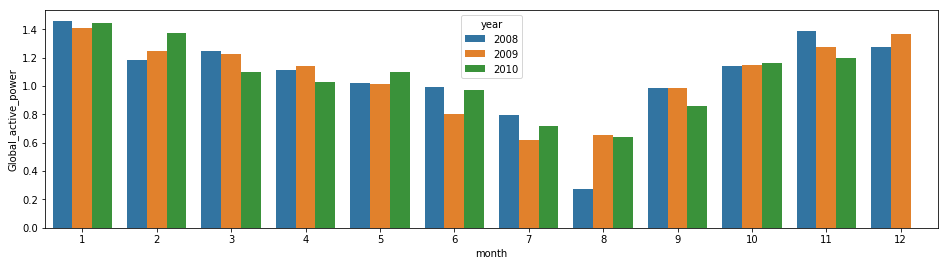

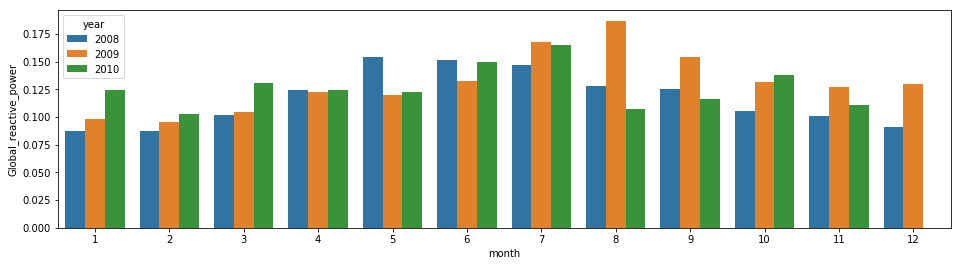

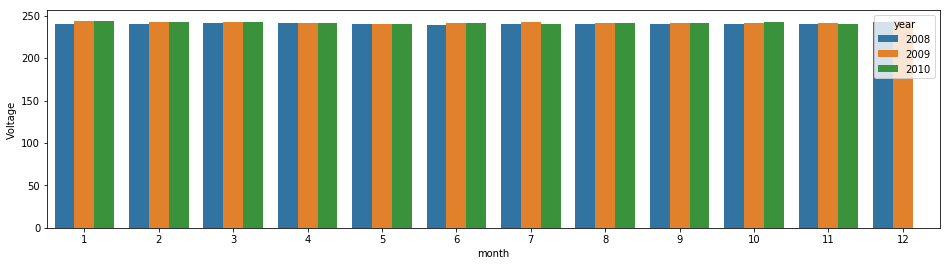

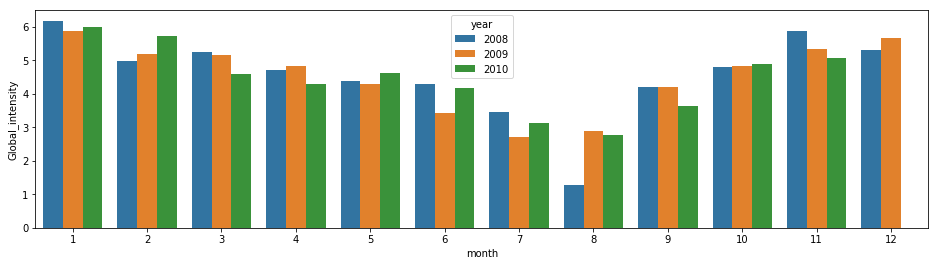

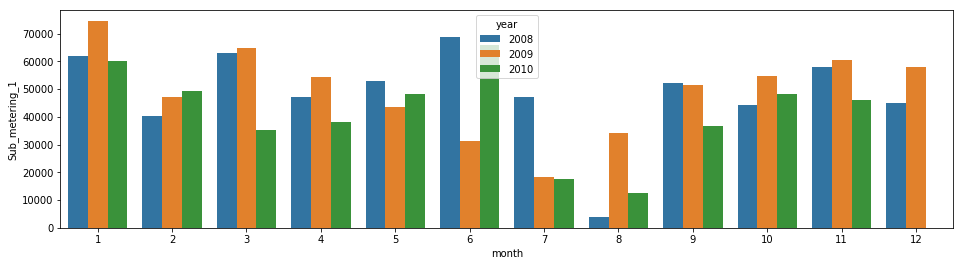

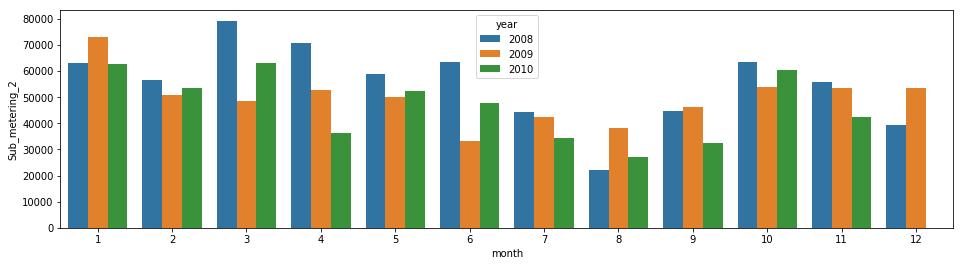

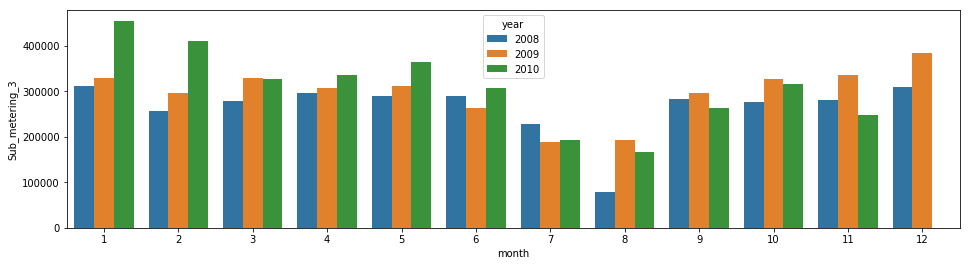

--------------------------------------------------------


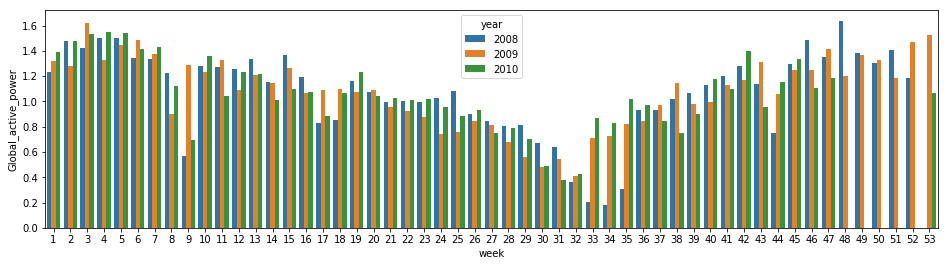

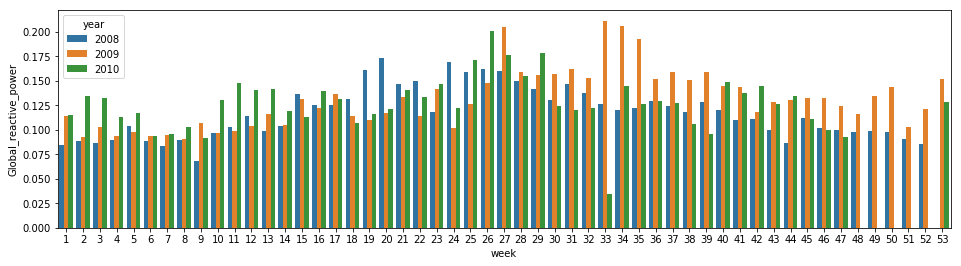

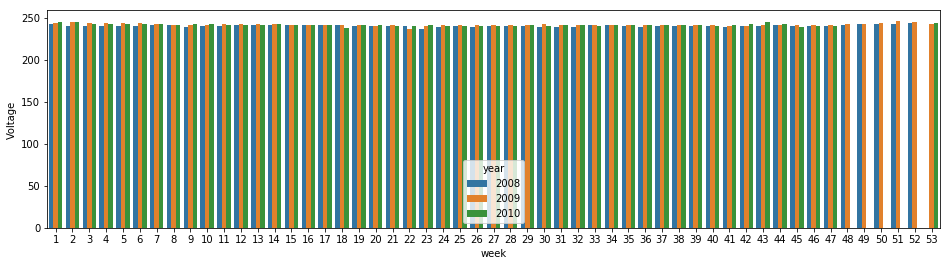

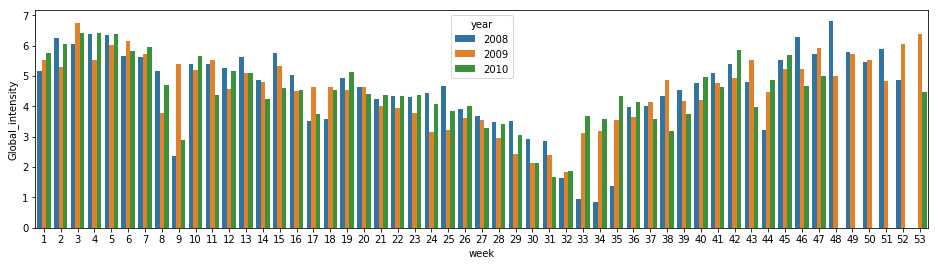

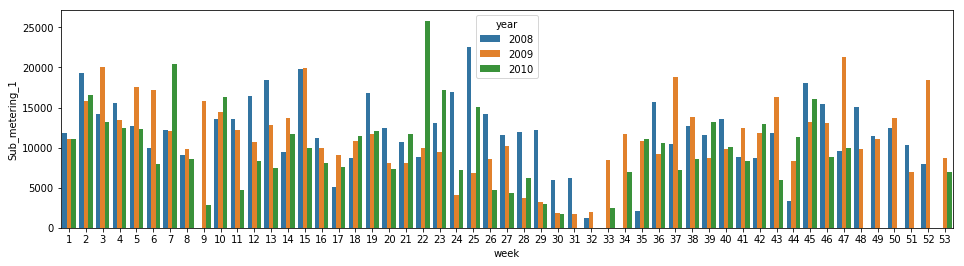

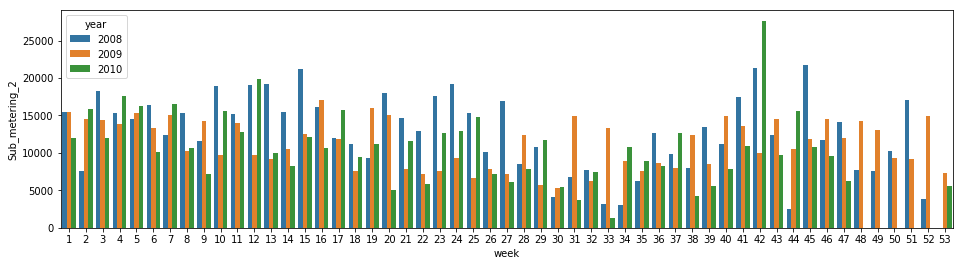

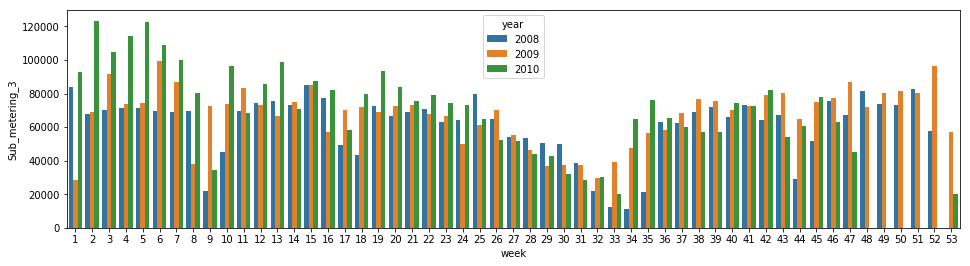

--------------------------------------------------------


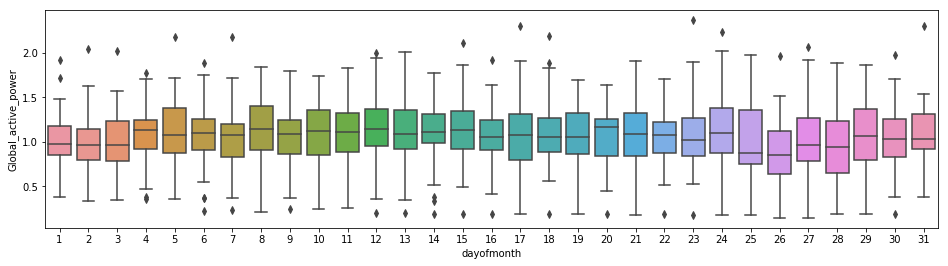

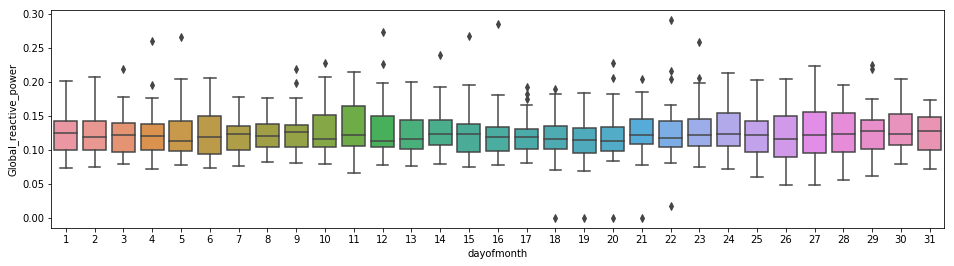

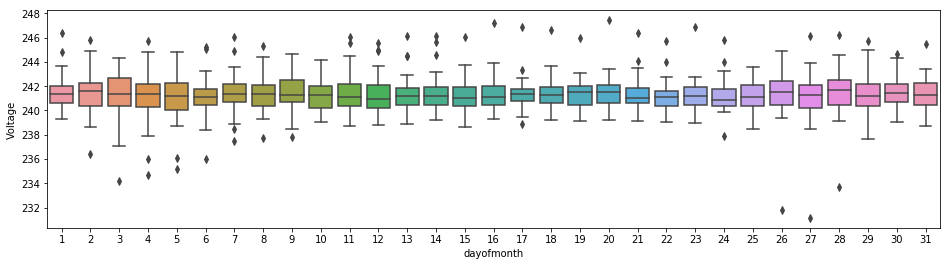

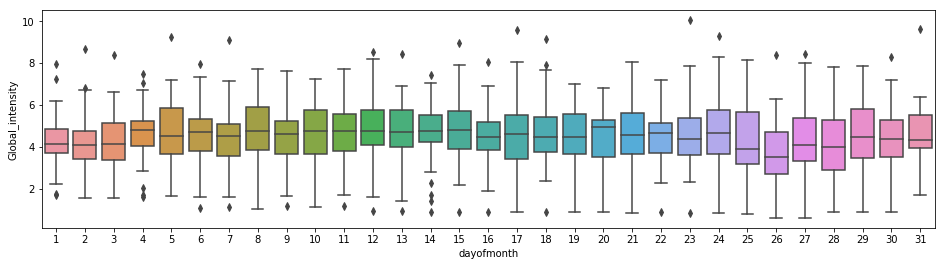

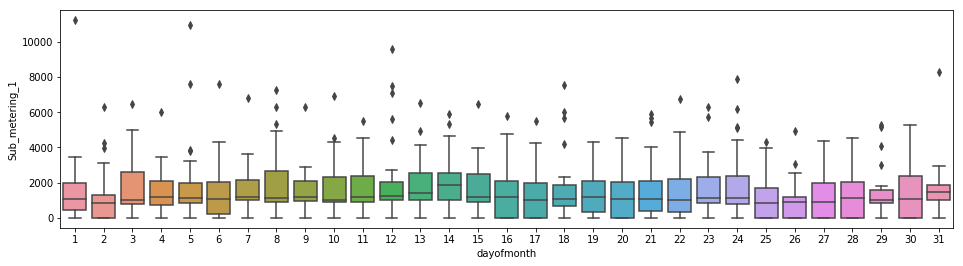

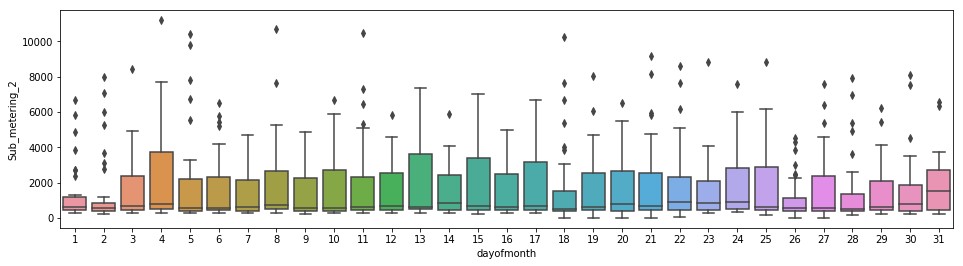

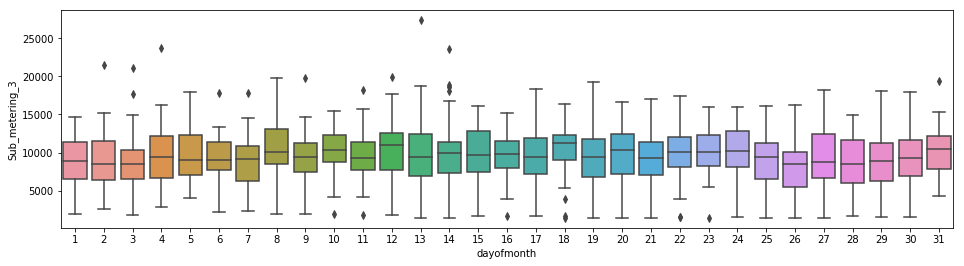

--------------------------------------------------------


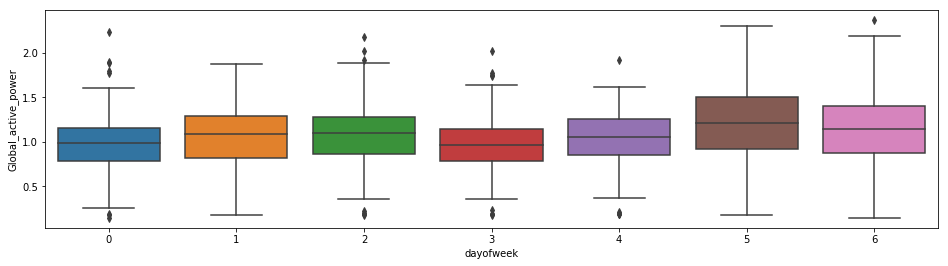

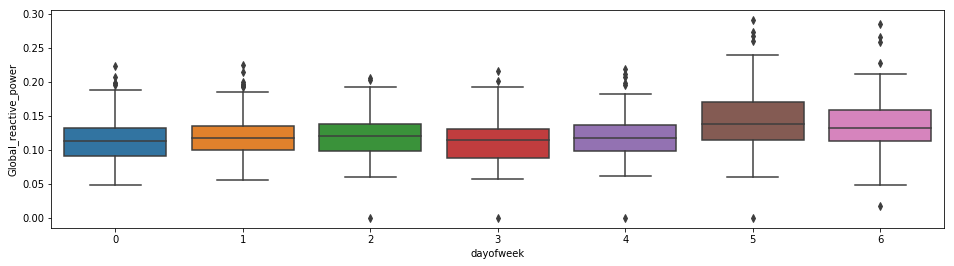

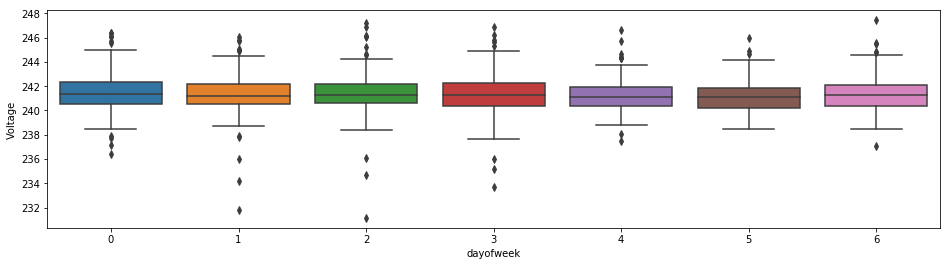

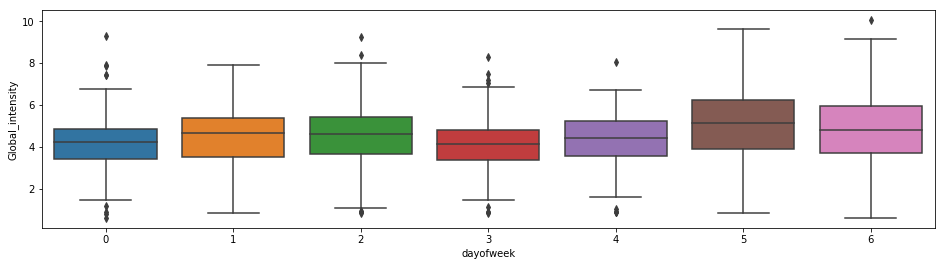

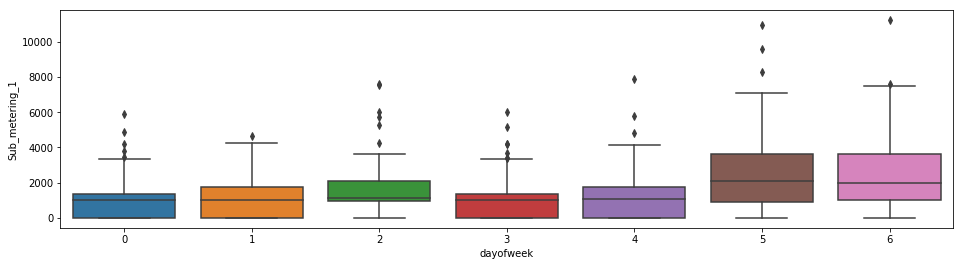

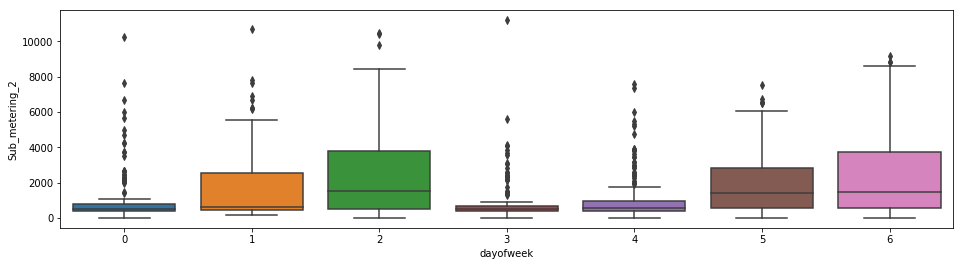

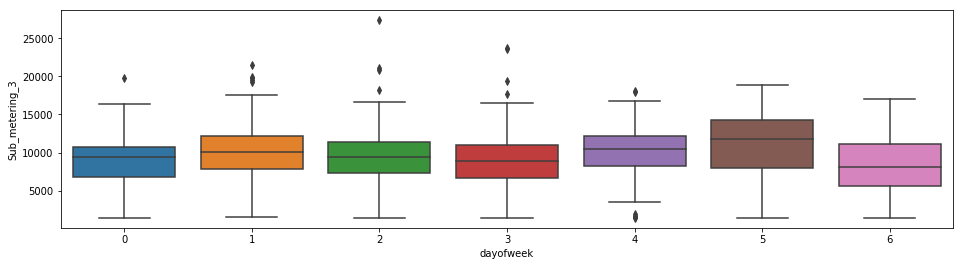

--------------------------------------------------------


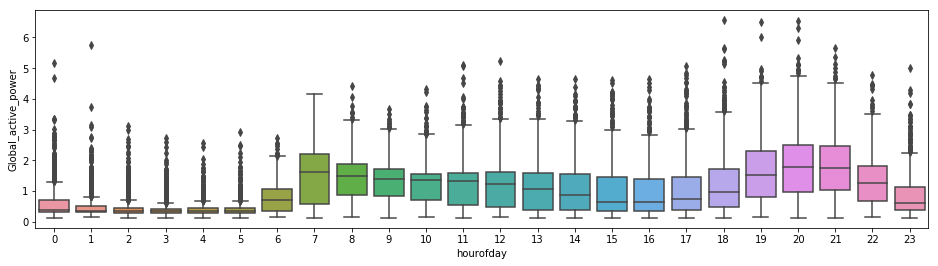

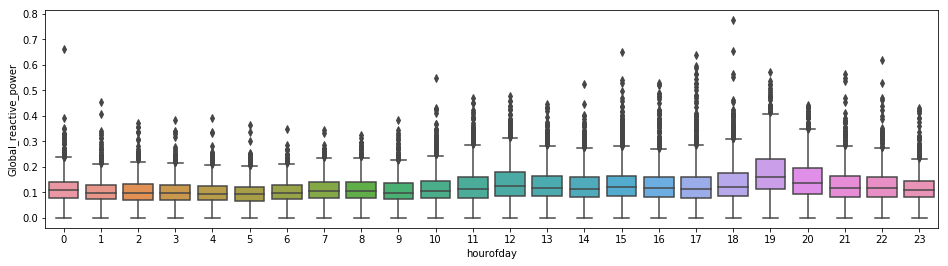

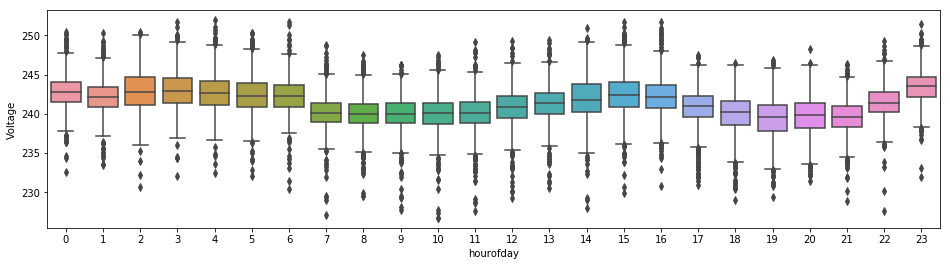

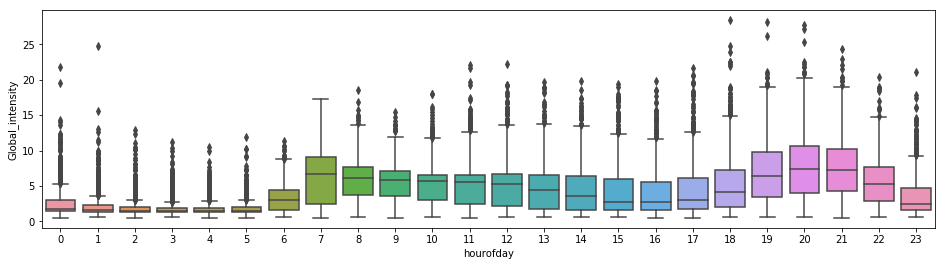

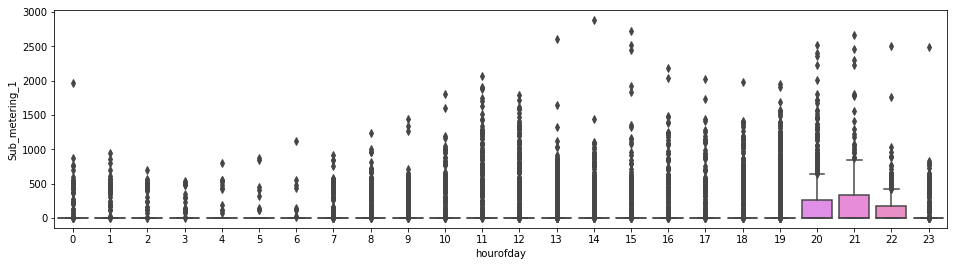

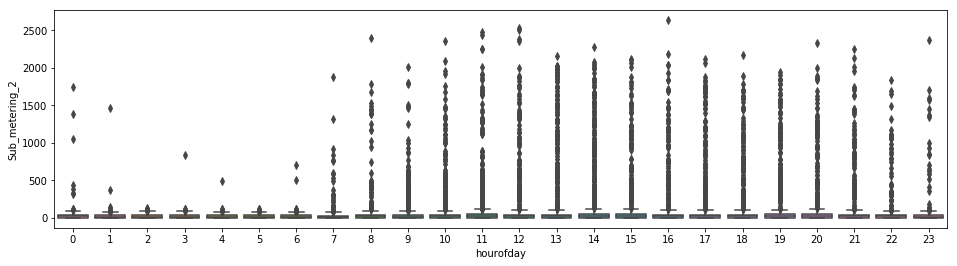

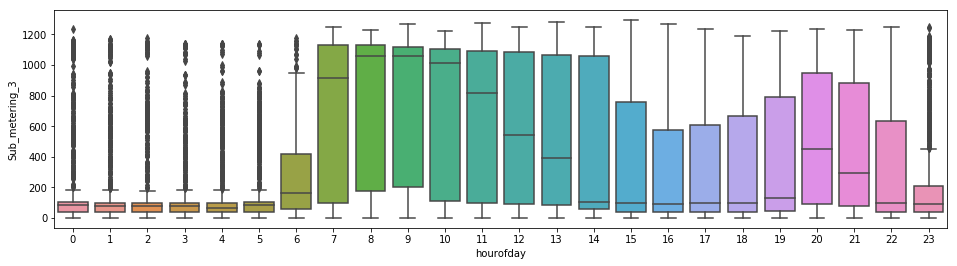

--------------------------------------------------------


In [9]:
check_seasonality2(df_treated,"month","year") #seasonal, less consumption in July,Aug
check_seasonality2(df_treated,"week","year") #seasonal, less consumption in weeks of July,Aug
check_seasonality1(df_treated,"dayofmonth","yearmo") #insignificant
check_seasonality1(df_treated,"dayofweek","yearwk") # not much seasonality wrt dayofweek
check_seasonality1(df_treated,"hourofday","yearday") # Huge sesonality as expected



## Model 

The objective of the challenge is to develop a machine learning model for predicting the total "Global_active_power" consumption during the next 7 days.

Assuming the granuality required is at day as its not mentioned in the problem statement.

In [10]:
def model_data_prep(df_treated,predict_lead_days=1,cutoff_dt=datetime.date(2010,7,1)):  
    
    agg_logic={'Global_active_power':'mean',
   'Global_reactive_power':'mean', 'Voltage':'mean', 'Global_intensity':'mean',
   'Sub_metering_1':'sum', 'Sub_metering_2':'sum', 'Sub_metering_3':'sum'}

    df_treated_day=df_treated.groupby(["date","week","month","dayofweek"]).agg(agg_logic).reset_index().set_index("date")
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_treated_day_scaled = pd.DataFrame(scaler.fit_transform(df_treated_day))
    df_treated_day_scaled.columns=df_treated_day.columns
    df_treated_day_scaled.index=df_treated_day.index
    df_treated_day_scaled.sort_index(inplace=True,ascending=False)
    #print(df_treated_day_scaled.head(2))

    
    lags=[1,2,365]
    df_list=[]
    df_list.append(df_treated_day_scaled)
    for i in lags:
        df_temp=df_treated_day_scaled.shift(-i)
        df_temp.columns=df_treated_day_scaled.columns+"lag_%d"%(i)
        df_list.append(df_temp)
    df_list.append(df_treated_day_scaled['Global_active_power'].shift(predict_lead_days).rename('label'))
    df_treated_day_scaled_withlags=pd.concat(df_list,axis=1).dropna() #Dropping NA rows coming because of lag
    #print(df_treated_day_scaled_withlags.head())
    
    df_intime = df_treated_day_scaled_withlags.loc[df_treated_day_scaled_withlags.index <= cutoff_dt,:]
    df_ootime = df_treated_day_scaled_withlags.loc[df_treated_day_scaled_withlags.index > cutoff_dt,:]
    print("Dates in df_intime are from ", df_intime.index.min()," to " , df_intime.index.max())
    print("Dates in df_intime are from ", df_ootime.index.min()," to " , df_ootime.index.max())
    
    print("Intime dataset", df_intime.shape)
    print("OOT dataset", df_ootime.shape)


    Xtrain, Xtest, ytrain, ytest = train_test_split(
        df_intime.drop(columns=['label']),
        df_intime['label'],
        test_size=0.2, random_state=201903)

    Xoot=df_ootime.drop(columns=['label'])
    yoot=df_ootime['label']
    
    return Xtrain, Xtest, ytrain, ytest,Xoot,yoot

def run_model(clf,evallist,i,params,nfold,early_stopping_rounds,Xtrain, Xtest, ytrain, ytest,Xoot,yoot): 
    start_time = datetime.datetime.now().time()
    
    print('Fit on the trainingsdata')
    clf.fit(Xtrain,ytrain,eval_set=evallist, early_stopping_rounds=early_stopping_rounds)    
    end_time = datetime.datetime.now().time()
    
    runtime = (end_time.hour - start_time.hour)*60 + (end_time.minute - start_time.minute) + (end_time.second - start_time.second)/60
    
    print("Took ",runtime, "Minutes")
    pred_train = clf.predict(Xtrain,output_margin=False, ntree_limit=None, validate_features=True)
    pred_test = clf.predict(Xtest,output_margin=False, ntree_limit=None, validate_features=True)
    pred_oot = clf.predict(Xoot,output_margin=False, ntree_limit=None, validate_features=True)
    
    results=pd.DataFrame(params,index=[i+1])
    results['train_auc'] = mean_squared_error(ytrain, pred_train)
    results['test_auc'] = mean_squared_error(ytest, pred_test)
    results['oot_auc'] = mean_squared_error(yoot, pred_oot)

    return results,clf



In [11]:
def _model(predict_lead_days=1):
    path="/mnt/flipkart/cremo/users/jatin.dixit/temp/Electricity_consumption_time_Series/results"
    Xtrain, Xtest, ytrain, ytest,Xoot,yoot=model_data_prep(df_treated,predict_lead_days=predict_lead_days)
    print(Xtrain.head(3))
    
    evallist = [(Xtrain, ytrain),(Xoot,yoot),(Xtest, ytest)]

    param_grid = {
    'learning_rate':[.01,.05,.1],
    'colsample_bytree': [.1,.2,.5],
    'max_depth' :[2,3,5],
    'min_child_weight': [2,10,30,90,270],
    'grow_policy': ['lossguide'],
    'n_estimators': [20000],
    'gamma':[2,4,9,16,25,36],
    'max_delta_step':[5,10],
    'eta' :[.01,.05,.1,.2,.4,.8],
    'eval_metric': ["rmse"],
    'objective': ['reg:linear'],
    'subsample' : [.1,.2,.4,.8]
    }

    n_iter=1000
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter,random_state=10))


    results_list=[]
    for i,param in enumerate(param_list):

        print("Running iteration", i+1, "of ", n_iter)
        clf = xgb.XGBRegressor(**param)
        results_list.append(run_model(clf,evallist,i,param,5,50,Xtrain, Xtest, ytrain, ytest,Xoot,yoot)[0])
    result_df=pd.concat(results_list)
    return result_df


In [ ]:
model_param_results={}
for i in range(7):
    predict_lead_days=i+1
    model_param_results["model_%d"%predict_lead_days]=_model(predict_lead_days)


In [13]:
df_predictions=pd.DataFrame()
model_best_param={}
models={}

for i in range(7):
    predict_lead_days=i+1
    df=model_param_results["model_%d"%predict_lead_days]
    param=df.loc[df['test_auc'].idxmin(),['learning_rate','colsample_bytree','max_depth' ,'min_child_weight','grow_policy','n_estimators','gamma','max_delta_step','eta' ,'eval_metric','objective','subsample']].to_dict()
    model_best_param["model_%d"%predict_lead_days]=param
    clf = xgb.XGBRegressor(**param)
    Xtrain, Xtest, ytrain, ytest,Xoot,yoot=model_data_prep(df_treated,predict_lead_days=predict_lead_days)
    evallist = [(Xtrain, ytrain),(Xoot,yoot),(Xtest, ytest)]    
    models["model_%d"%predict_lead_days]=run_model(clf,evallist,i,model_best_param["model_%d"%predict_lead_days],5,50,Xtrain, Xtest, ytrain, ytest,Xoot,yoot)[1]
    
    
    
df_pred_list=[]
for i in range(7):
    Xtrain, Xtest, ytrain, ytest,Xoot,yoot=model_data_prep(df_treated,predict_lead_days=predict_lead_days)    
    df_predictions= pd.DataFrame({"pred_lead_%d"%(i):models["model_%d"%(i+1)].predict(Xoot),"actual_lead_%d"%(i):yoot})
    df_pred_list.append(df_predictions)
df_pred_list.append(Xoot)
results = pd.concat(df_pred_list,axis=1)
    
    

Dates in df_intime are from  2008-12-31  to  2010-07-01
Dates in df_intime are from  2010-07-02  to  2010-11-25
Intime dataset (548, 41)
OOT dataset (147, 41)
Fit on the trainingsdata
[0]	validation_0-rmse:0.166468	validation_1-rmse:0.218531	validation_2-rmse:0.18209
Multiple eval metrics have been passed: 'validation_2-rmse' will be used for early stopping.

Will train until validation_2-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.165533	validation_1-rmse:0.216778	validation_2-rmse:0.181079
[2]	validation_0-rmse:0.162484	validation_1-rmse:0.211785	validation_2-rmse:0.177917
[3]	validation_0-rmse:0.161516	validation_1-rmse:0.209869	validation_2-rmse:0.176868
[4]	validation_0-rmse:0.158618	validation_1-rmse:0.205049	validation_2-rmse:0.173866
[5]	validation_0-rmse:0.157788	validation_1-rmse:0.20331	validation_2-rmse:0.172963
[6]	validation_0-rmse:0.15715	validation_1-rmse:0.201929	validation_2-rmse:0.172264
[7]	validation_0-rmse:0.154829	validation_1-rmse:0.197639	validat

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[68]	validation_0-rmse:0.142828	validation_1-rmse:0.165147	validation_2-rmse:0.156544
[69]	validation_0-rmse:0.142833	validation_1-rmse:0.165367	validation_2-rmse:0.15657
[70]	validation_0-rmse:0.14283	validation_1-rmse:0.165252	validation_2-rmse:0.156556
[71]	validation_0-rmse:0.142827	validation_1-rmse:0.16511	validation_2-rmse:0.15654
[72]	validation_0-rmse:0.142826	validation_1-rmse:0.165031	validation_2-rmse:0.156531
[73]	validation_0-rmse:0.142825	validation_1-rmse:0.164991	validation_2-rmse:0.156527
[74]	validation_0-rmse:0.142825	validation_1-rmse:0.164964	validation_2-rmse:0.156524
[75]	validation_0-rmse:0.142824	validation_1-rmse:0.164847	validation_2-rmse:0.156511
[76]	validation_0-rmse:0.142824	validation_1-rmse:0.164888	validation_2-rmse:0.156516
[77]	validation_0-rmse:0.142825	validation_1-rmse:0.164939	validation_2-rmse:0.156521
[78]	validation_0-rmse:0.142823	validation_1-rmse:0.164718	validation_2-rmse:0.156498
[79]	validation_0-rmse:0.142823	validation_1-rmse:0.164757

[13]	validation_0-rmse:0.156315	validation_1-rmse:0.183109	validation_2-rmse:0.144725
[14]	validation_0-rmse:0.156192	validation_1-rmse:0.18233	validation_2-rmse:0.144342
[15]	validation_0-rmse:0.156048	validation_1-rmse:0.181304	validation_2-rmse:0.143851
[16]	validation_0-rmse:0.155958	validation_1-rmse:0.180577	validation_2-rmse:0.143513
[17]	validation_0-rmse:0.15275	validation_1-rmse:0.177869	validation_2-rmse:0.140107
[18]	validation_0-rmse:0.152683	validation_1-rmse:0.177225	validation_2-rmse:0.139809
[19]	validation_0-rmse:0.15265	validation_1-rmse:0.176865	validation_2-rmse:0.139646
[20]	validation_0-rmse:0.152608	validation_1-rmse:0.176363	validation_2-rmse:0.139422
[21]	validation_0-rmse:0.152571	validation_1-rmse:0.175845	validation_2-rmse:0.139196
[22]	validation_0-rmse:0.152541	validation_1-rmse:0.175356	validation_2-rmse:0.138987
[23]	validation_0-rmse:0.152531	validation_1-rmse:0.175164	validation_2-rmse:0.138906
[24]	validation_0-rmse:0.152525	validation_1-rmse:0.17503

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[65]	validation_0-rmse:0.152482	validation_1-rmse:0.172952	validation_2-rmse:0.138028
[66]	validation_0-rmse:0.152485	validation_1-rmse:0.172619	validation_2-rmse:0.137905
[67]	validation_0-rmse:0.152482	validation_1-rmse:0.172878	validation_2-rmse:0.138
[68]	validation_0-rmse:0.152483	validation_1-rmse:0.172791	validation_2-rmse:0.137968
[69]	validation_0-rmse:0.152481	validation_1-rmse:0.173017	validation_2-rmse:0.138052
[70]	validation_0-rmse:0.152481	validation_1-rmse:0.172962	validation_2-rmse:0.138031
[71]	validation_0-rmse:0.152481	validation_1-rmse:0.173017	validation_2-rmse:0.138052
[72]	validation_0-rmse:0.152481	validation_1-rmse:0.172977	validation_2-rmse:0.138037
[73]	validation_0-rmse:0.152482	validation_1-rmse:0.172909	validation_2-rmse:0.138012
[74]	validation_0-rmse:0.152482	validation_1-rmse:0.172891	validation_2-rmse:0.138005
[75]	validation_0-rmse:0.152481	validation_1-rmse:0.173024	validation_2-rmse:0.138055
[76]	validation_0-rmse:0.152481	validation_1-rmse:0.17322

[41]	validation_0-rmse:0.153183	validation_1-rmse:0.178635	validation_2-rmse:0.153942
[42]	validation_0-rmse:0.153185	validation_1-rmse:0.178863	validation_2-rmse:0.154043
[43]	validation_0-rmse:0.153184	validation_1-rmse:0.178743	validation_2-rmse:0.15399
[44]	validation_0-rmse:0.153185	validation_1-rmse:0.178839	validation_2-rmse:0.154033
[45]	validation_0-rmse:0.153183	validation_1-rmse:0.178687	validation_2-rmse:0.153965
[46]	validation_0-rmse:0.153185	validation_1-rmse:0.178833	validation_2-rmse:0.15403
[47]	validation_0-rmse:0.153183	validation_1-rmse:0.178662	validation_2-rmse:0.153954
[48]	validation_0-rmse:0.153182	validation_1-rmse:0.178522	validation_2-rmse:0.153892
[49]	validation_0-rmse:0.153181	validation_1-rmse:0.178401	validation_2-rmse:0.153838
[50]	validation_0-rmse:0.153181	validation_1-rmse:0.178211	validation_2-rmse:0.153755
[51]	validation_0-rmse:0.153181	validation_1-rmse:0.178216	validation_2-rmse:0.153757
[52]	validation_0-rmse:0.153181	validation_1-rmse:0.1783

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[64]	validation_0-rmse:0.14996	validation_1-rmse:0.174189	validation_2-rmse:0.150923
[65]	validation_0-rmse:0.149959	validation_1-rmse:0.174667	validation_2-rmse:0.151138
[66]	validation_0-rmse:0.149959	validation_1-rmse:0.174374	validation_2-rmse:0.151006
[67]	validation_0-rmse:0.14996	validation_1-rmse:0.174301	validation_2-rmse:0.150973
[68]	validation_0-rmse:0.149961	validation_1-rmse:0.174122	validation_2-rmse:0.150893
[69]	validation_0-rmse:0.14996	validation_1-rmse:0.174241	validation_2-rmse:0.150946
[70]	validation_0-rmse:0.149961	validation_1-rmse:0.174164	validation_2-rmse:0.150912
[71]	validation_0-rmse:0.149961	validation_1-rmse:0.174115	validation_2-rmse:0.15089
[72]	validation_0-rmse:0.14996	validation_1-rmse:0.174312	validation_2-rmse:0.150978
[73]	validation_0-rmse:0.149964	validation_1-rmse:0.173913	validation_2-rmse:0.150801
[74]	validation_0-rmse:0.149965	validation_1-rmse:0.173857	validation_2-rmse:0.150776
[75]	validation_0-rmse:0.149964	validation_1-rmse:0.173884	

[30]	validation_0-rmse:0.15	validation_1-rmse:0.170759	validation_2-rmse:0.147631
[31]	validation_0-rmse:0.149997	validation_1-rmse:0.170628	validation_2-rmse:0.147643
[32]	validation_0-rmse:0.15	validation_1-rmse:0.170767	validation_2-rmse:0.14763
[33]	validation_0-rmse:0.149994	validation_1-rmse:0.170446	validation_2-rmse:0.147662
[34]	validation_0-rmse:0.14999	validation_1-rmse:0.170122	validation_2-rmse:0.147698
[35]	validation_0-rmse:0.149995	validation_1-rmse:0.170545	validation_2-rmse:0.147652
[36]	validation_0-rmse:0.149992	validation_1-rmse:0.170342	validation_2-rmse:0.147673
[37]	validation_0-rmse:0.149991	validation_1-rmse:0.170164	validation_2-rmse:0.147693
[38]	validation_0-rmse:0.149993	validation_1-rmse:0.170382	validation_2-rmse:0.147669
[39]	validation_0-rmse:0.14999	validation_1-rmse:0.170126	validation_2-rmse:0.147697
[40]	validation_0-rmse:0.149991	validation_1-rmse:0.17022	validation_2-rmse:0.147686
[41]	validation_0-rmse:0.14999	validation_1-rmse:0.169977	validati

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[61]	validation_0-rmse:0.149993	validation_1-rmse:0.169608	validation_2-rmse:0.147763
[62]	validation_0-rmse:0.149993	validation_1-rmse:0.16959	validation_2-rmse:0.147765
[63]	validation_0-rmse:0.149991	validation_1-rmse:0.169761	validation_2-rmse:0.147742
[64]	validation_0-rmse:0.149993	validation_1-rmse:0.169554	validation_2-rmse:0.14777
[65]	validation_0-rmse:0.149991	validation_1-rmse:0.169755	validation_2-rmse:0.147743
[66]	validation_0-rmse:0.149993	validation_1-rmse:0.169587	validation_2-rmse:0.147766
[67]	validation_0-rmse:0.149994	validation_1-rmse:0.169513	validation_2-rmse:0.147776
[68]	validation_0-rmse:0.149996	validation_1-rmse:0.169384	validation_2-rmse:0.147794
[69]	validation_0-rmse:0.149994	validation_1-rmse:0.169496	validation_2-rmse:0.147778
Stopping. Best iteration:
[19]	validation_0-rmse:0.150184	validation_1-rmse:0.173496	validation_2-rmse:0.1475

Took  0.0 Minutes
Dates in df_intime are from  2008-12-31  to  2010-07-01
Dates in df_intime are from  2010-07-02  to

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[60]	validation_0-rmse:0.147525	validation_1-rmse:0.171004	validation_2-rmse:0.158795
[61]	validation_0-rmse:0.147525	validation_1-rmse:0.170982	validation_2-rmse:0.158797
[62]	validation_0-rmse:0.147525	validation_1-rmse:0.171012	validation_2-rmse:0.158794
[63]	validation_0-rmse:0.14753	validation_1-rmse:0.170781	validation_2-rmse:0.158818
[64]	validation_0-rmse:0.14753	validation_1-rmse:0.170762	validation_2-rmse:0.15882
[65]	validation_0-rmse:0.147525	validation_1-rmse:0.171012	validation_2-rmse:0.158794
[66]	validation_0-rmse:0.147524	validation_1-rmse:0.171058	validation_2-rmse:0.158789
[67]	validation_0-rmse:0.147522	validation_1-rmse:0.17124	validation_2-rmse:0.158772
[68]	validation_0-rmse:0.147523	validation_1-rmse:0.171114	validation_2-rmse:0.158784
[69]	validation_0-rmse:0.147521	validation_1-rmse:0.171375	validation_2-rmse:0.15876
[70]	validation_0-rmse:0.147521	validation_1-rmse:0.17143	validation_2-rmse:0.158755
[71]	validation_0-rmse:0.147521	validation_1-rmse:0.171314	v

[155]	validation_0-rmse:0.147533	validation_1-rmse:0.17067	validation_2-rmse:0.15883
[156]	validation_0-rmse:0.147533	validation_1-rmse:0.170651	validation_2-rmse:0.158833
[157]	validation_0-rmse:0.147529	validation_1-rmse:0.170798	validation_2-rmse:0.158816
[158]	validation_0-rmse:0.147524	validation_1-rmse:0.171096	validation_2-rmse:0.158786
[159]	validation_0-rmse:0.147522	validation_1-rmse:0.171224	validation_2-rmse:0.158773
[160]	validation_0-rmse:0.147522	validation_1-rmse:0.171236	validation_2-rmse:0.158772
[161]	validation_0-rmse:0.147521	validation_1-rmse:0.171538	validation_2-rmse:0.158746
[162]	validation_0-rmse:0.147522	validation_1-rmse:0.171281	validation_2-rmse:0.158768
[163]	validation_0-rmse:0.147521	validation_1-rmse:0.171295	validation_2-rmse:0.158767
Stopping. Best iteration:
[113]	validation_0-rmse:0.147524	validation_1-rmse:0.171963	validation_2-rmse:0.158713

Took  0.016666666666666666 Minutes
Dates in df_intime are from  2008-12-31  to  2010-07-01
Dates in df_in

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[62]	validation_0-rmse:0.152798	validation_1-rmse:0.172943	validation_2-rmse:0.138556
[63]	validation_0-rmse:0.152798	validation_1-rmse:0.172895	validation_2-rmse:0.138545
[64]	validation_0-rmse:0.152796	validation_1-rmse:0.173036	validation_2-rmse:0.138576
[65]	validation_0-rmse:0.152794	validation_1-rmse:0.173412	validation_2-rmse:0.138661
[66]	validation_0-rmse:0.152794	validation_1-rmse:0.173373	validation_2-rmse:0.138652
[67]	validation_0-rmse:0.152794	validation_1-rmse:0.173534	validation_2-rmse:0.13869
[68]	validation_0-rmse:0.152795	validation_1-rmse:0.173256	validation_2-rmse:0.138625
[69]	validation_0-rmse:0.152795	validation_1-rmse:0.173564	validation_2-rmse:0.138697
[70]	validation_0-rmse:0.152795	validation_1-rmse:0.173605	validation_2-rmse:0.138706
[71]	validation_0-rmse:0.152794	validation_1-rmse:0.173539	validation_2-rmse:0.138691
[72]	validation_0-rmse:0.152794	validation_1-rmse:0.173426	validation_2-rmse:0.138664
[73]	validation_0-rmse:0.152795	validation_1-rmse:0.173

[52]	validation_0-rmse:0.148587	validation_1-rmse:0.172636	validation_2-rmse:0.141586
[53]	validation_0-rmse:0.148585	validation_1-rmse:0.172535	validation_2-rmse:0.14154
[54]	validation_0-rmse:0.148584	validation_1-rmse:0.172518	validation_2-rmse:0.141532
[55]	validation_0-rmse:0.14858	validation_1-rmse:0.172259	validation_2-rmse:0.141415
[56]	validation_0-rmse:0.148579	validation_1-rmse:0.172112	validation_2-rmse:0.141349
[57]	validation_0-rmse:0.148579	validation_1-rmse:0.172005	validation_2-rmse:0.141301
[58]	validation_0-rmse:0.148579	validation_1-rmse:0.172045	validation_2-rmse:0.141319
[59]	validation_0-rmse:0.148578	validation_1-rmse:0.171814	validation_2-rmse:0.141216
[60]	validation_0-rmse:0.148579	validation_1-rmse:0.171726	validation_2-rmse:0.141177
[61]	validation_0-rmse:0.148579	validation_1-rmse:0.171707	validation_2-rmse:0.141169
[62]	validation_0-rmse:0.148581	validation_1-rmse:0.1715	validation_2-rmse:0.141079
[63]	validation_0-rmse:0.148582	validation_1-rmse:0.171449

/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/mnt/flipkart/cremo/venv/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[70]	validation_0-rmse:0.148579	validation_1-rmse:0.171723	validation_2-rmse:0.141176
[71]	validation_0-rmse:0.148578	validation_1-rmse:0.171861	validation_2-rmse:0.141237
[72]	validation_0-rmse:0.148579	validation_1-rmse:0.172042	validation_2-rmse:0.141317
[73]	validation_0-rmse:0.148578	validation_1-rmse:0.171825	validation_2-rmse:0.141221
[74]	validation_0-rmse:0.14858	validation_1-rmse:0.171622	validation_2-rmse:0.141132
[75]	validation_0-rmse:0.148579	validation_1-rmse:0.171764	validation_2-rmse:0.141194
[76]	validation_0-rmse:0.148579	validation_1-rmse:0.172075	validation_2-rmse:0.141332
[77]	validation_0-rmse:0.148578	validation_1-rmse:0.171886	validation_2-rmse:0.141248
[78]	validation_0-rmse:0.148578	validation_1-rmse:0.171866	validation_2-rmse:0.141239
[79]	validation_0-rmse:0.148578	validation_1-rmse:0.17186	validation_2-rmse:0.141236
[80]	validation_0-rmse:0.148579	validation_1-rmse:0.171799	validation_2-rmse:0.141209
[81]	validation_0-rmse:0.148578	validation_1-rmse:0.1718

[165]	validation_0-rmse:0.148578	validation_1-rmse:0.171927	validation_2-rmse:0.141266
[166]	validation_0-rmse:0.148578	validation_1-rmse:0.171952	validation_2-rmse:0.141277
[167]	validation_0-rmse:0.148582	validation_1-rmse:0.172361	validation_2-rmse:0.141461
[168]	validation_0-rmse:0.148582	validation_1-rmse:0.172354	validation_2-rmse:0.141458
[169]	validation_0-rmse:0.14858	validation_1-rmse:0.172208	validation_2-rmse:0.141392
[170]	validation_0-rmse:0.148578	validation_1-rmse:0.171932	validation_2-rmse:0.141268
[171]	validation_0-rmse:0.148579	validation_1-rmse:0.171816	validation_2-rmse:0.141217
Stopping. Best iteration:
[121]	validation_0-rmse:0.148586	validation_1-rmse:0.171196	validation_2-rmse:0.140948

Took  0.016666666666666666 Minutes
Dates in df_intime are from  2008-12-31  to  2010-07-01
Dates in df_intime are from  2010-07-02  to  2010-11-19
Intime dataset (548, 41)
OOT dataset (141, 41)
Dates in df_intime are from  2008-12-31  to  2010-07-01
Dates in df_intime are from 

In [26]:
model_best_param

{'model_1': {'colsample_bytree': 0.20000000000000001,
  'eta': 0.80000000000000004,
  'eval_metric': 'rmse',
  'gamma': 2,
  'grow_policy': 'lossguide',
  'learning_rate': 0.050000000000000003,
  'max_delta_step': 10,
  'max_depth': 2,
  'min_child_weight': 30,
  'n_estimators': 20000,
  'objective': 'reg:linear',
  'subsample': 0.80000000000000004},
 'model_2': {'colsample_bytree': 0.5,
  'eta': 0.20000000000000001,
  'eval_metric': 'rmse',
  'gamma': 2,
  'grow_policy': 'lossguide',
  'learning_rate': 0.10000000000000001,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_weight': 2,
  'n_estimators': 20000,
  'objective': 'reg:linear',
  'subsample': 0.80000000000000004},
 'model_3': {'colsample_bytree': 0.5,
  'eta': 0.20000000000000001,
  'eval_metric': 'rmse',
  'gamma': 2,
  'grow_policy': 'lossguide',
  'learning_rate': 0.10000000000000001,
  'max_delta_step': 5,
  'max_depth': 2,
  'min_child_weight': 2,
  'n_estimators': 20000,
  'objective': 'reg:linear',
  'subsample': 0

In [27]:
models

{'model_1': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.20000000000000001, eta=0.80000000000000004,
        eval_metric='rmse', gamma=2, grow_policy='lossguide',
        importance_type='gain', learning_rate=0.050000000000000003,
        max_delta_step=10, max_depth=2, min_child_weight=30, missing=None,
        n_estimators=20000, n_jobs=1, nthread=None, objective='reg:linear',
        random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
        seed=None, silent=True, subsample=0.80000000000000004),
 'model_2': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.5, eta=0.20000000000000001, eval_metric='rmse',
        gamma=2, grow_policy='lossguide', importance_type='gain',
        learning_rate=0.10000000000000001, max_delta_step=5, max_depth=2,
        min_child_weight=2, missing=None, n_estimators=20000, n_jobs=1,
        nthread=None, objective='reg:linear', random_state=0, reg_

In [48]:
#Second level of tuning is required for lags to be used. Not covered.
#Tuning features is also required for much better results. 

In [49]:
models["model_1"].feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.26462489,
        0.25078437,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.24043266,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.24415809], dtype=float32)

In [50]:
results.head(10)

,actual_lead_0,pred_lead_0,actual_lead_1,pred_lead_1,actual_lead_2,pred_lead_2,actual_lead_3,pred_lead_3,actual_lead_4,pred_lead_4,...,weeklag_365,monthlag_365,dayofweeklag_365,Sub_metering_1lag_365,Global_intensitylag_365,Global_active_powerlag_365,Sub_metering_3lag_365,Sub_metering_2lag_365,Voltagelag_365,Global_reactive_powerlag_365
date,,,,,,,,,,,,,,,,,,,,,
2010-11-19,0.465006,0.446808,0.465006,0.434302,0.465006,0.433233,0.465006,0.450051,0.465006,0.442977,...,0.884615,0.909091,0.500000,0.000000,0.386429,0.395618,0.366456,0.042973,0.726250,0.356730
2010-11-18,0.381952,0.439361,0.381952,0.434302,0.381952,0.448573,0.381952,0.434095,0.381952,0.412098,...,0.884615,0.909091,0.333333,0.535638,0.749956,0.759863,0.476431,0.683910,0.623231,0.487945
2010-11-17,0.496164,0.439361,0.496164,0.434302,0.496164,0.448573,0.496164,0.434095,0.496164,0.442977,...,0.884615,0.909091,0.166667,0.000000,0.456533,0.468649,0.392686,0.040472,0.706948,0.401183
2010-11-16,0.427742,0.446808,0.427742,0.434302,0.427742,0.433233,0.427742,0.450051,0.427742,0.442977,...,0.884615,0.909091,0.000000,0.180061,0.402525,0.408012,0.305431,0.048691,0.659335,0.376212
2010-11-15,0.572899,0.439361,0.572899,0.434302,0.572899,0.448573,0.572899,0.434095,0.572899,0.442977,...,0.865385,0.909091,1.000000,0.088293,0.548083,0.549678,0.308980,0.471545,0.563613,0.505339
2010-11-14,0.216068,0.439361,0.216068,0.434302,0.216068,0.448573,0.216068,0.434095,0.216068,0.442977,...,0.865385,0.909091,0.833333,0.371436,0.725363,0.735237,0.672427,0.215402,0.557293,0.588387
2010-11-13,0.621536,0.446808,0.621536,0.434302,0.621536,0.433233,0.621536,0.450051,0.621536,0.442977,...,0.865385,0.909091,0.666667,0.165360,0.408155,0.413787,0.298642,0.036362,0.619489,0.375585
2010-11-12,0.425510,0.446808,0.425510,0.434302,0.425510,0.433233,0.425510,0.450051,0.425510,0.442977,...,0.865385,0.909091,0.500000,0.132395,0.386664,0.391932,0.307321,0.038328,0.679087,0.366648
2010-11-11,0.451085,0.439361,0.451085,0.434302,0.451085,0.448573,0.451085,0.434095,0.451085,0.442977,...,0.865385,0.909091,0.333333,0.208304,0.568854,0.572569,0.377179,0.456089,0.689195,0.533868


In [51]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_obj(models,"selected_best_models_dict")
save_obj(model_best_param,"selected_best_params_dict")
save_obj(model_param_results,"param_Search_dict")

results.to_csv("results.csv")

In [52]:
for i in range(7):
    print("Mean square error for lead %d days is "%i,mean_squared_error(results["actual_lead_%d"%i],results["pred_lead_%d"%i]))
    
    

Mean square error for lead 0 days is  0.0280235963827
Mean square error for lead 1 days is  0.0304411037052
Mean square error for lead 2 days is  0.0303470016036
Mean square error for lead 3 days is  0.0303952247026
Mean square error for lead 4 days is  0.0294117774082
Mean square error for lead 5 days is  0.0296440822421
Mean square error for lead 6 days is  0.0293081444052
